# <center> <img src="../../img/ITESOLogo.png" alt="ITESO" width="480" height="130"> </center>
# <center> **Departamento de Electrónica, Sistemas e Informática** </center>
---
## <center> Computer Systems Engineering  </center>
---
### <center> Big Data Processing </center>
---
#### <center> **Autumn 2025** </center>
---

**Lab 05**: Data pipeline with Neo4j

**Date**: October 3rd 2025

**Student Name**: Luis Adrian Bravo Ramirez

**Professor**: Pablo Camarillo Ramirez

# Dataset description

The dataset chosen by me is called "The Marvel Universe Social Network". \
It is found on: https://www.kaggle.com/datasets/csanhueza/the-marvel-universe-social-network?select=nodes.csv

This dataset contains the following nodes:
- Comic (Node)
- Hero (Node)

And it also contains the following edges:
- Hero [Source] > Hero  [Target]
- Hero [Source] > Comic [Target]

So basically, this will show two different nodes on the graph that will have two different relationships between them, 'INTERACTS_WITH' for _Hero > Hero_ relationship and 'APPEARS_IN' for _Hero > Comic_ relationship. 

# Data ingestion

In [1]:
import findspark
findspark.init()

from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Examples on SparkSQL") \
    .master("spark://spark-master:7077") \
    .config("spark.jars.packages", "org.neo4j:neo4j-connector-apache-spark_2.13:5.3.10_for_spark_3") \
    .config("spark.ui.port", "4040") \
    .getOrCreate()

sc = spark.sparkContext
sc.setLogLevel("ERROR")

:: loading settings :: url = jar:file:/opt/spark/jars/ivy-2.5.3.jar!/org/apache/ivy/core/settings/ivysettings.xml
Ivy Default Cache set to: /root/.ivy2.5.2/cache
The jars for the packages stored in: /root/.ivy2.5.2/jars
org.neo4j#neo4j-connector-apache-spark_2.13 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-211f17b6-279f-49f2-8a94-8143531eec95;1.0
	confs: [default]
	found org.neo4j#neo4j-connector-apache-spark_2.13;5.3.10_for_spark_3 in central
	found org.neo4j#neo4j-connector-apache-spark_2.13_common;5.3.10_for_spark_3 in central
	found org.neo4j#caniuse-core;1.3.0 in central
	found org.neo4j#caniuse-api;1.3.0 in central
	found org.jetbrains.kotlin#kotlin-stdlib;2.1.20 in central
	found org.jetbrains#annotations;13.0 in central
	found org.neo4j#caniuse-neo4j-detection;1.3.0 in central
	found org.neo4j.driver#neo4j-java-driver-slim;4.4.21 in central
	found org.reactivestreams#reactive-streams;1.0.4 in central
	found io.netty#netty-handler;4.1.

In [2]:
# Import your module
from luisbravor00.spark_utils import SparkUtils
from pyspark.sql.functions import col, trim

# Build nodes schema
nodes_schema_columns = [
    ("name", "string"),
    ("type", "string")
]

# Build INTERACTS_WITH relationship schema (Hero > Hero)
interacts_with_schema_columns = [
    ("hero1", "string"),
    ("hero2", "string")
]

# Build APPEARS_IN relationship schema (Hero > Comic)
appears_in_schema_columns = [
    ("hero", "string"),
    ("comic", "string")
]

# Create schemas
nodes_schema = SparkUtils.generate_schema(nodes_schema_columns)
interacts_with_schema = SparkUtils.generate_schema(interacts_with_schema_columns)
appears_in_schema = SparkUtils.generate_schema(appears_in_schema_columns)

# Read CSV files and store them on dataframes
nodes_df = spark.read \
    .option("header", "true") \
    .schema(nodes_schema) \
    .csv("/opt/spark/work-dir/data/marvel/nodes.csv")

interacts_with_df = spark.read \
    .option("header", "true") \
    .schema(interacts_with_schema) \
    .csv("/opt/spark/work-dir/data/marvel/hero-network.csv")

interacts_with_df = interacts_with_df \
    .withColumn("hero1", trim(col("hero1"))) \
    .withColumn("hero2", trim(col("hero2")))

appears_in_df = spark.read \
    .option("header", "true") \
    .schema(appears_in_schema) \
    .csv("/opt/spark/work-dir/data/marvel/edges.csv")

appears_in_df = appears_in_df \
    .withColumn("hero", trim(col("hero"))) \
    .withColumn("comic", trim(col("comic")))

# Transformations

In [3]:
# Add the code for your transformations to create nodes and edges DataFrames HERE
# Hero Nodes
hero_nodes = nodes_df.filter(col("type") == "hero").select(
    col("name").alias("hero_name"),
    col("type")
).dropDuplicates(["hero_name", "type"])

hero_nodes.show(n=5)
hero_nodes.count()

+-----------------+----+
|        hero_name|type|
+-----------------+----+
|           ANTORO|hero|
|CRIME-WAVE/HOLLIS|hero|
| DIAMONDE, YVETTE|hero|
|      DRAN, DAMON|hero|
|FLEX/ADRIAN CORBO|hero|
+-----------------+----+
only showing top 5 rows


6439

In [4]:
# Comic Nodes
comic_nodes = nodes_df.filter(col("type") == "comic").select(
    col("name").alias("comic_name"),
    col("type")
).dropDuplicates(["comic_name", "type"])

comic_nodes.show(n=5)
comic_nodes.count()

+----------+-----+
|comic_name| type|
+----------+-----+
|     A 326|comic|
|      A 78|comic|
|    AA2 39|comic|
|   ALF 1/6|comic|
| ARCHANGEL|comic|
+----------+-----+
only showing top 5 rows


12651

In [5]:
# Hero > Hero EDGES
# Limit to 1000 because there are a lot of rows
hero_hero_edges = interacts_with_df.select(
    col("hero1").alias("source_hero"),
    col("hero2").alias("target_hero")
).dropDuplicates(["source_hero", "target_hero"])

hero_hero_edges.show(n=5)
hero_hero_edges.count()

+-------------------+--------------------+
|        source_hero|         target_hero|
+-------------------+--------------------+
|   ROM, SPACEKNIGHT|       RESTON, CLIVE|
|               UATU|THING/BENJAMIN J. GR|
|ANDROMEDA/ANDROMEDA|     CAPTAIN AMERICA|
|        INFINITY II|ANGEL/WARREN KENNETH|
|         LORD CHAOS| INVISIBLE WOMAN/SUE|
+-------------------+--------------------+
only showing top 5 rows


224111

In [6]:
# Hero > Comic EDGES
hero_comic_edges = appears_in_df.select(
    col("hero").alias("source_hero"),
    col("comic").alias("target_comic")
).dropDuplicates(["source_hero", "target_comic"])

hero_comic_edges.show(n=5)
hero_comic_edges.count()

+--------------------+------------+
|         source_hero|target_comic|
+--------------------+------------+
|ABOMINATION/EMIL BLO|     M/SH3 8|
|ABOMINATION | MUTANT|      MX '01|
|ANGEL/WARREN KENNETH|     CHAMP 7|
|ANGEL/WARREN KENNETH|       UX 15|
|ANGEL/WARREN KENNETH|        UX 2|
+--------------------+------------+
only showing top 5 rows


96104

# Writing Data in Neo4j

In [7]:
# Add the code to write a graph from PySpark's DataFrames to Neo4j
neo4j_url = "bolt://neo4j-iteso:7687"
neo4j_user = "neo4j"
neo4j_passwd = "neo4j@1234"
hero_nodes.write \
  .format("org.neo4j.spark.DataSource") \
  .mode("Overwrite") \
  .option("url", neo4j_url) \
  .option("authentication.basic.username", neo4j_user) \
  .option("authentication.basic.password", neo4j_passwd) \
  .option("labels", ":Hero") \
  .option("node.keys", "hero_name") \
  .save()

print(f"{hero_nodes.count()} Heroes wrote in Neo4j")

comic_nodes.write \
  .format("org.neo4j.spark.DataSource") \
  .mode("Overwrite") \
  .option("url", neo4j_url) \
  .option("authentication.basic.username", neo4j_user) \
  .option("authentication.basic.password", neo4j_passwd) \
  .option("labels", ":Comic") \
  .option("node.keys", "comic_name") \
  .save()

print(f"{comic_nodes.count()} Comics wrote in Neo4j")

# Limit EDGES to 1000 because there are a lot of rows
hero_hero_edges = hero_hero_edges.limit(1000)
hero_comic_edges = hero_comic_edges.limit(1000)

hero_hero_edges.write \
  .format("org.neo4j.spark.DataSource") \
  .mode("Append") \
  .option("url", neo4j_url) \
  .option("authentication.basic.username", neo4j_user) \
  .option("authentication.basic.password", neo4j_passwd) \
  .option("relationship", "INTERACTS_WITH") \
  .option("relationship.save.strategy", "keys") \
  .option("relationship.source.labels", ":Hero") \
  .option("relationship.source.save.mode", "match") \
  .option("relationship.source.node.keys", "source_hero:hero_name") \
  .option("relationship.target.labels", ":Hero") \
  .option("relationship.target.save.mode", "match") \
  .option("relationship.target.node.keys", "target_hero:hero_name") \
  .save()

print(f"{hero_hero_edges.count()} Hero > Hero edges wrote in Neo4j")

hero_comic_edges.write \
  .format("org.neo4j.spark.DataSource") \
  .mode("Append") \
  .option("url", neo4j_url) \
  .option("authentication.basic.username", neo4j_user) \
  .option("authentication.basic.password", neo4j_passwd) \
  .option("relationship", "APPEARS_IN") \
  .option("relationship.save.strategy", "keys") \
  .option("relationship.source.labels", ":Hero") \
  .option("relationship.source.save.mode", "match") \
  .option("relationship.source.node.keys", "source_hero:hero_name") \
  .option("relationship.target.labels", ":Comic") \
  .option("relationship.target.save.mode", "match") \
  .option("relationship.target.node.keys", "target_comic:comic_name") \
  .save()

print(f"{hero_comic_edges.count()} Hero > Comic edges wrote in Neo4j")

6439 Heroes wrote in Neo4j


12651 Comics wrote in Neo4j


1000 Hero > Hero edges wrote in Neo4j


1000 Hero > Comic edges wrote in Neo4j


# Read and Query Graphs with PySpark

In [8]:
# Add the code to read a data frame from Neo4J and run a simple query to verify 
cypher1_df = spark.read \
    .format("org.neo4j.spark.DataSource") \
    .option("url", neo4j_url) \
    .option("authentication.basic.username", neo4j_user) \
    .option("authentication.basic.password", neo4j_passwd) \
    .option("query",
            """
            MATCH (h1:Hero)-[r:INTERACTS_WITH]->(h2:Hero)
            WHERE h1.hero_name = "CAGE, LUKE/CARL LUCA"
            RETURN h1.hero_name, h2.hero_name
            """) \
    .load()

cypher1_df.show()

+--------------------+--------------------+
|        h1.hero_name|        h2.hero_name|
+--------------------+--------------------+
|CAGE, LUKE/CARL LUCA|              SHADES|
|CAGE, LUKE/CARL LUCA|TOMBSTONE/LONNIE THO|
+--------------------+--------------------+



# Same query from Neo4j localhost
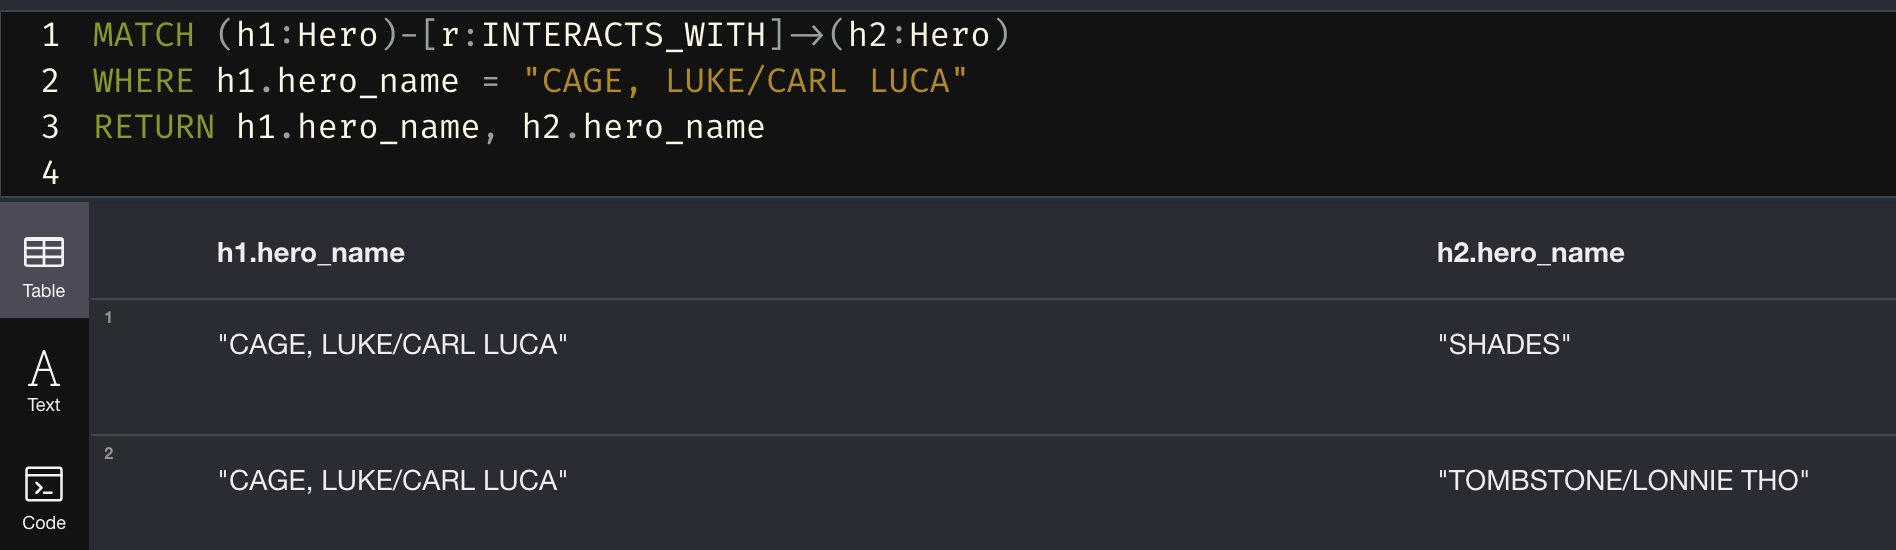

In [9]:
cypher2_df = spark.read \
    .format("org.neo4j.spark.DataSource") \
    .option("url", neo4j_url) \
    .option("authentication.basic.username", neo4j_user) \
    .option("authentication.basic.password", neo4j_passwd) \
    .option("query",
            """
            MATCH (h:Hero)-[r:APPEARS_IN]->(c:Comic)
            WHERE c.comic_name IN ["A '99", "A '1", "A '10", "A 107"]
            RETURN h.hero_name, c.comic_name
            """) \
    .load()

cypher2_df.show()

+--------------------+------------+
|         h.hero_name|c.comic_name|
+--------------------+------------+
|FIRESTAR/ANGELICA JO|       A '99|
|       SPACE PHANTOM|       A 107|
+--------------------+------------+



# Same query from Neo4j localhost
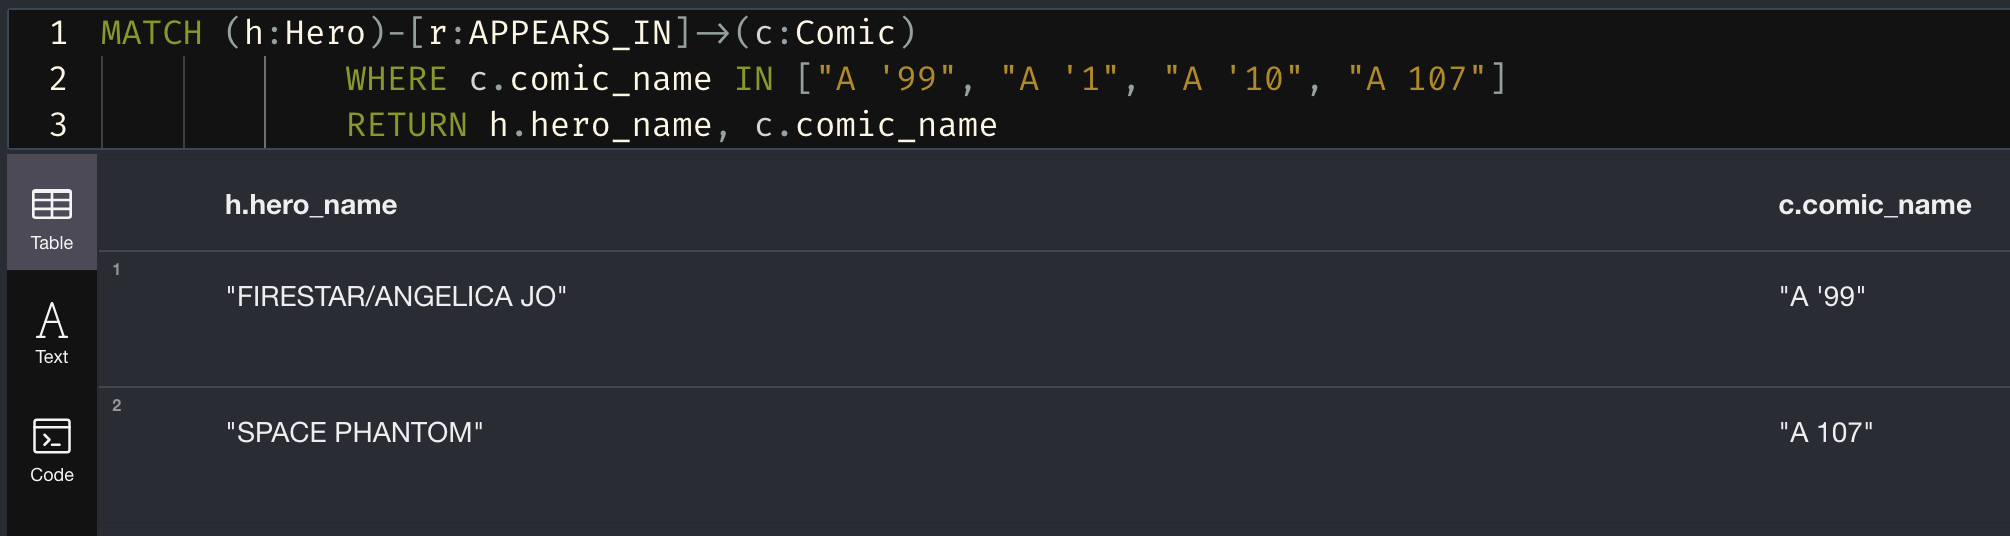

In [10]:
sc.stop()